# Import libraries

In [85]:
import pandas as pd, numpy as np
import os
import math
from math import ceil, floor, log
import random

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
from sklearn import preprocessing

import seaborn as sns

from yellowbrick.classifier import ClassificationReport
import scikitplot as skplt

from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import catboost
print(catboost.__version__)
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

import scikitplot as skplt

0.24.1


# Data loading and setup

In [86]:
SEED = 1970
random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
path = '../input/health-insurance-cross-sell-prediction/'

Data loading and preprocessing (feature engineering)...

In [87]:
df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")

col_list = df_train.columns.to_list()[1:]
df_train_corr = df_train.copy().set_index('id')
df_train_ones = df_train_corr.loc[df_train_corr.Response == 1].copy()

categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# code text categorical features
le = preprocessing.LabelEncoder()
for f in text_features :
    df_train_corr[f] = le.fit_transform(df_train_corr[f])
# change digital categorical datatype so CatBoost can deal with them
df_train_corr.Region_Code = df_train_corr.Region_Code.astype('int32')
df_train_corr.Policy_Sales_Channel = df_train_corr.Policy_Sales_Channel.astype('int32')

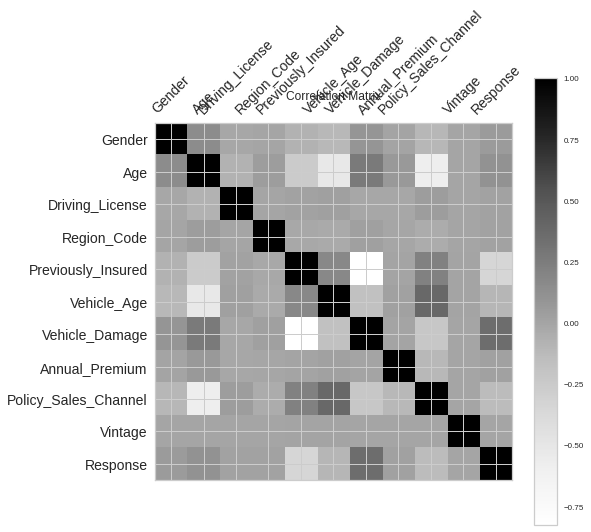

In [88]:
f = plt.figure(figsize=(8, 8))
plt.matshow(df_train_corr.corr(), fignum=f.number)
plt.xticks(range(df_train_corr.shape[1]), df_train_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_train_corr.shape[1]), df_train_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=12);

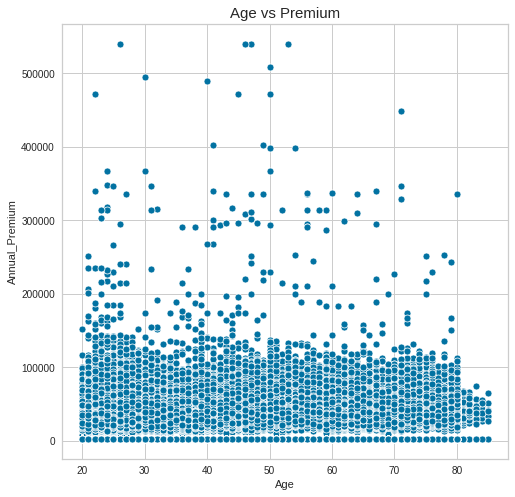

In [89]:
plt.figure(figsize = (8, 8))
sns.scatterplot(df_train_corr['Age'],df_train_corr['Annual_Premium'])
plt.title('Age vs Premium', fontsize = 15)
plt.show()

In [90]:
bins = [10,20, 30, 40, 50, 60, 70, 80, 90, 100]
df_train_corr['bin_age'] = pd.cut(df_train_corr['Age'], bins)
df_train_corr['bin_age']
df_train_corr['age_bin_cat'] = le.fit_transform(df_train_corr['bin_age'])
df_train_corr['age_bin_cat'].value_counts()

1    155229
3     75941
2     55163
4     45305
5     27838
6     15272
0      6232
7       129
Name: age_bin_cat, dtype: int64

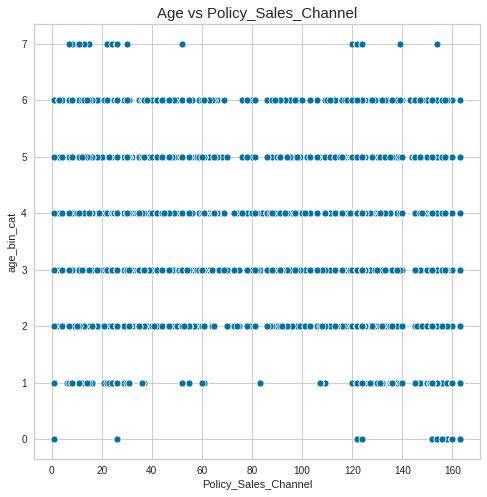

In [91]:
plt.figure(figsize = (8, 8))
sns.scatterplot(df_train_corr['Policy_Sales_Channel'],df_train_corr['age_bin_cat'])
# sns.scatterplot(df_train_corr['age_bin_cat'],df_train_corr['Policy_Sales_Channel'])
plt.title('Age vs Policy_Sales_Channel', fontsize = 15)
plt.show()

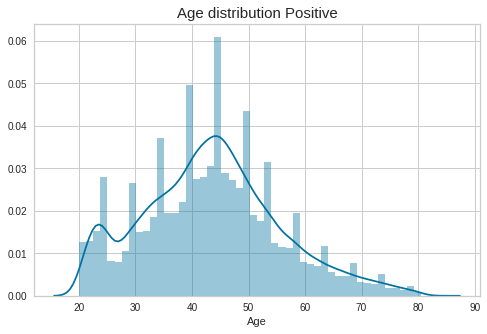

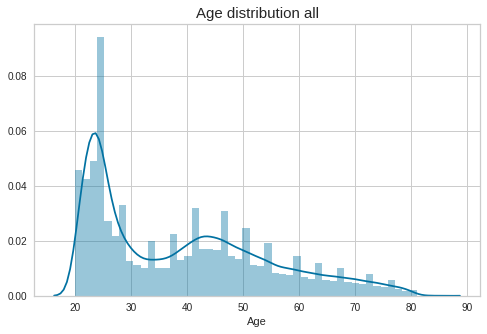

In [92]:
plt.figure(figsize = (8, 5))
sns.distplot(df_train_ones['Age'])
plt.title('Age distribution Positive', fontsize = 15)
plt.show()

plt.figure(figsize = (8, 5))
sns.distplot(df_train_corr['Age'])
plt.title('Age distribution all', fontsize = 15)
plt.show()

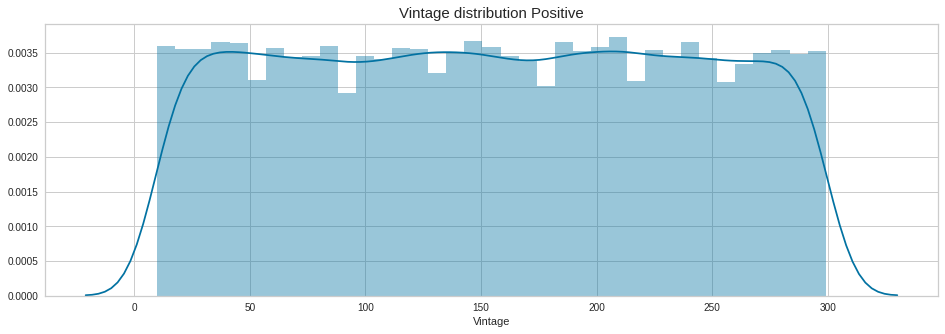

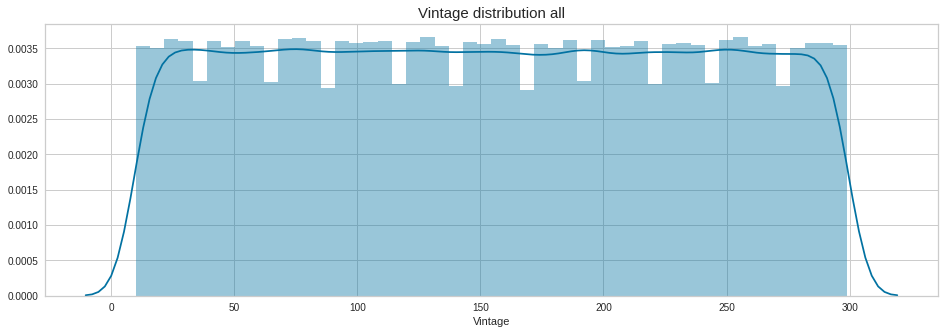

In [93]:
plt.figure(figsize = (16, 5))
sns.distplot(df_train_ones['Vintage'])
plt.title('Vintage distribution Positive', fontsize = 15)
plt.show()

plt.figure(figsize = (16, 5))
sns.distplot(df_train_corr['Vintage'])
plt.title('Vintage distribution all', fontsize = 15)
plt.show()

In [94]:
X = df_train_corr.loc[:,:'Vintage']
y = df_train_corr.Response
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state = SEED)
        
print(y_train.value_counts())
X_train.head()

0    267547
1     37340
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
74933,1,23,1,31,0,1,1,2630.0,160,52
74767,0,24,1,14,1,1,0,36238.0,152,223
46813,0,25,1,21,0,1,1,32979.0,152,169
56592,0,25,1,5,1,1,0,24476.0,152,202
109992,1,30,1,8,1,0,0,32797.0,26,211


In [12]:
def plot_ROC(fpr, tpr, m_name):
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic for %s'%m_name, fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

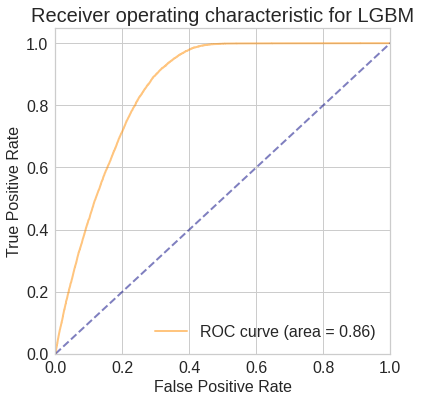

In [13]:
LGB_model = LGBMClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, min_child_weight = 1, verbose  = 1,
                       learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc', is_higher_better = 1, plot = True)
LGB_model.fit(X_train, y_train)
LGB_preds = LGB_model.predict_proba(X_valid)
LGB_class = LGB_model.predict(X_valid)
LGB_score = roc_auc_score(y_valid, LGB_preds[:,1], average = 'weighted')
(fpr, tpr, thresholds) = roc_curve(y_valid, LGB_preds[:,1])
plot_ROC(fpr, tpr, 'LGBM')

ROC AUC score for LGBM model: 0.8574
F1 score: 0.0528


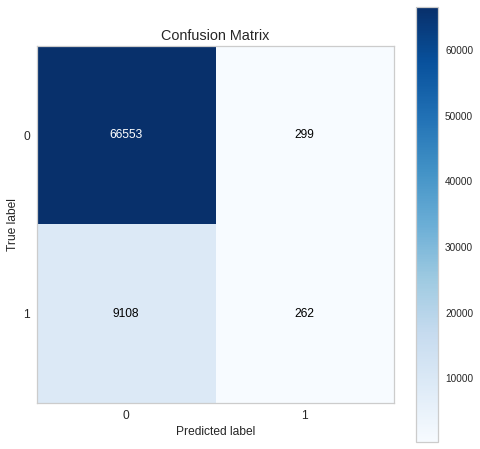

In [14]:
print('ROC AUC score for LGBM model: %.4f'%LGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, LGB_class))
# print('Confusion matrix:')
# print(confusion_matrix(y_valid, LGB_class))
skplt.metrics.plot_confusion_matrix(y_valid, LGB_class,
        figsize=(8,8))

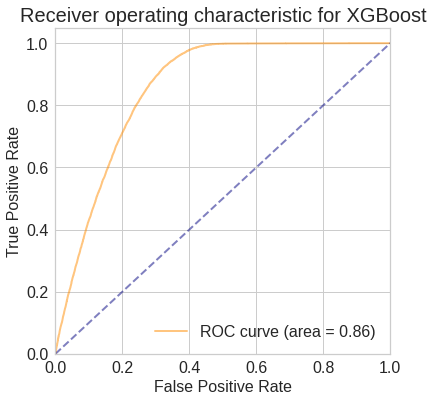

In [15]:
XGB_model = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')
XGB_model.fit(X_train, y_train)
XGB_preds = XGB_model.predict_proba(X_valid)
XGB_class = XGB_model.predict(X_valid)
XGB_score = roc_auc_score(y_valid, XGB_preds[:,1], average = 'weighted')

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds[:,1])
plot_ROC(fpr, tpr, 'XGBoost')

ROC AUC score for XGBoost model: 0.8553
F1 score: 0.0750


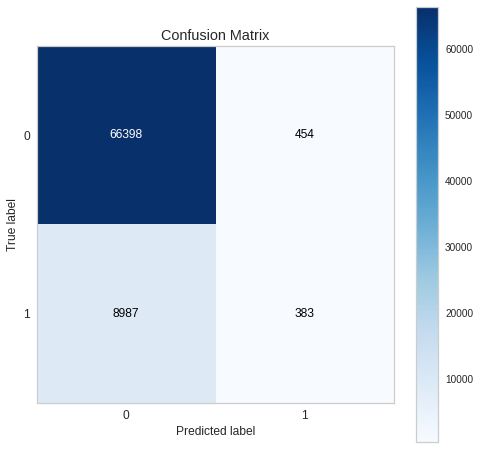

In [16]:
print('ROC AUC score for XGBoost model: %.4f'%XGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class))
# print('Confusion matrix:')
# print(confusion_matrix(y_valid, XGB_class))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class,
        figsize=(8,8))

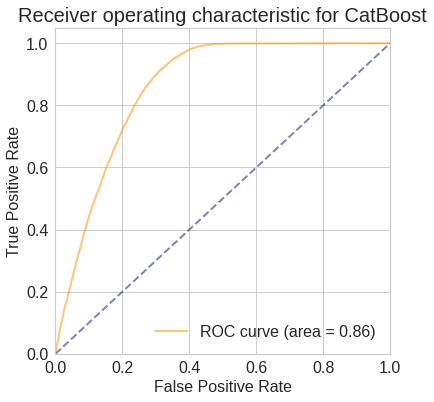

In [17]:
Cat_model = CatBoostClassifier( iterations = 300, random_seed = SEED, task_type = 'CPU',
    learning_rate = 0.5, custom_loss = ['AUC', 'Accuracy']
    )
Cat_model.fit(X_train, y_train, cat_features = categorical_features, eval_set = (X_valid, y_valid), verbose = False, plot = False)
Cat_preds = Cat_model.predict_proba(X_valid)
Cat_class = Cat_model.predict(X_valid)
Cat_score = roc_auc_score(y_valid, Cat_preds[:,1], average = 'weighted')
(fpr, tpr, thresholds) = roc_curve(y_valid, Cat_preds[:,1])
plot_ROC(fpr, tpr, 'CatBoost')

ROC AUC score for CatBoost model: 0.8578
F1 score: 0.0401


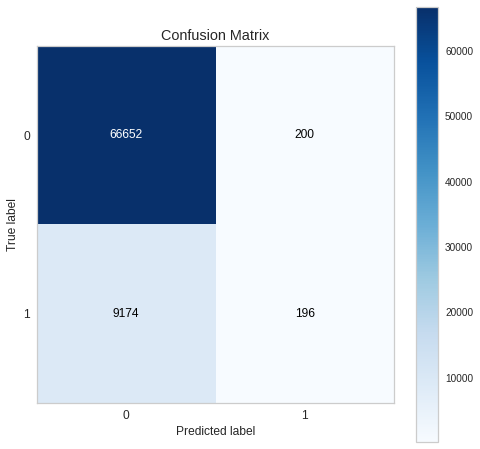

In [18]:
print('ROC AUC score for CatBoost model: %.4f'%Cat_score)
print('F1 score: %0.4f'%f1_score(y_valid, Cat_class))
# print('Confusion matrix:')
# print(confusion_matrix(y_valid, Cat_class))
skplt.metrics.plot_confusion_matrix(y_valid, Cat_class,
        figsize=(8,8))

Lets check if ensembling would give us some boost. <span style="text-decoration: line-through;">And it looks like it's not really helpful in this case. </span>After analyzing confusion matrices we actually see that all 3 models have terrible false negative rate, and underwhelming F1 score therefore (although somewhat decent AUC).  Moreover averaged result is even worse despite slightly increasing AUC  :(

Averaged score: 0.8585
Averaged F1 score: 0.0199


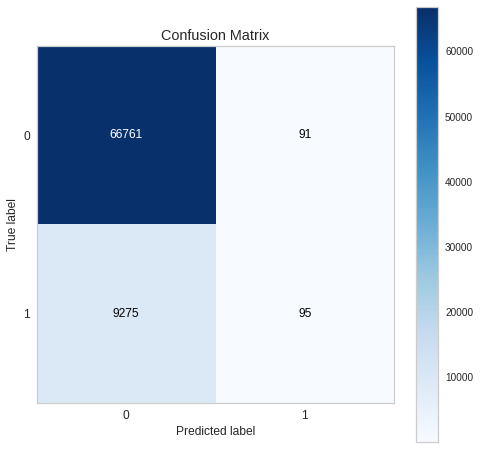

In [19]:
# plain averaging
avg_preds3 = (Cat_preds+LGB_preds+XGB_preds)/3
avg_class3 = ((Cat_class+LGB_class+XGB_class)/3).astype('int32')
score_avg3 = roc_auc_score(y_valid, avg_preds3[:,1], average = 'weighted')
print('Averaged score: %.4f'%score_avg3)
print('Averaged F1 score: %.4f'%f1_score(y_valid, avg_class3))
# print('Confusion matrix:')
# print(confusion_matrix(y_valid, avg_class3))
skplt.metrics.plot_confusion_matrix(y_valid, avg_class3,
        figsize=(8,8))

Now lets check if converting remaining categorical values to one-hot encoded features would help XGBoost.

In [20]:
df_train_01 = df_train.copy().set_index('id')
for f in categorical_features:
    df_train_01[f] = le.fit_transform(df_train_01[f])

# df_train_01.head()
y01 = df_train_01.Response
X01 = df_train_01.loc[:,:'Vintage']

sales = pd.get_dummies(X01.Policy_Sales_Channel, prefix = 'Sales')
code = pd.get_dummies(X01.Region_Code, prefix = 'Code')
vehicle_age = pd.get_dummies(X01.Vehicle_Age, prefix = 'Vehicle_Age')
X_one_hot = pd.concat([X01, sales], axis = 1)
X_one_hot = pd.concat([X_one_hot, code], axis = 1)
X_one_hot = pd.concat([X_one_hot, vehicle_age], axis = 1)
X_one_hot = X_one_hot.drop(columns = ['Policy_Sales_Channel','Region_Code', 'Vehicle_Age'])
print(X_one_hot.columns)

Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'Sales_0', 'Sales_1', 'Sales_2',
       ...
       'Code_46', 'Code_47', 'Code_48', 'Code_49', 'Code_50', 'Code_51', 'Code_52', 'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2'], dtype='object', length=218)


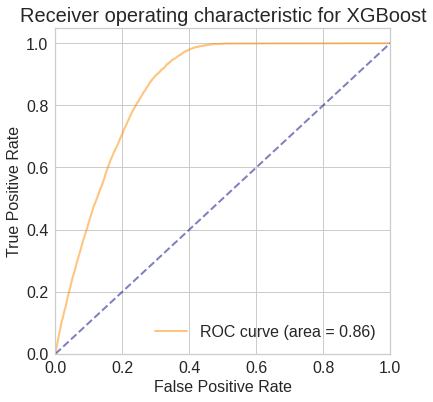

In [21]:
X0_train, X0_valid, y0_train, y0_valid = train_test_split(X_one_hot, y01, train_size=0.8, random_state = SEED)

XGB_model_01 = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')
XGB_model_01.fit(X0_train, y0_train)
XGB_preds0 = XGB_model_01.predict_proba(X0_valid)
XGB_score0 = roc_auc_score(y0_valid, XGB_preds0[:,1], average = 'weighted')
XGB_class0 = XGB_model_01.predict(X0_valid)

(fpr, tpr, thresholds) = roc_curve(y0_valid, XGB_preds0[:,1])
plot_ROC(fpr, tpr,'XGBoost')

In [22]:
print('ROC AUC score for XGBoost model with One Hot Encoded categorical features: %.4f'%XGB_score0)
print('F1 score: %0.4f'%f1_score(y0_valid, XGB_class0))
print('Confusion matrix:')
print(confusion_matrix(y_valid, XGB_class0))
# and for easier comparison lets do it again here
print('-'*20)
print('ROC AUC score for XGBoost model with categorical features not encoded: %.4f'%XGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class))
print('Confusion matrix with categorical features not encoded:')
print(confusion_matrix(y_valid, XGB_class))

ROC AUC score for XGBoost model with One Hot Encoded categorical features: 0.8552
F1 score: 0.0654
Confusion matrix:
[[66465   387]
 [ 9040   330]]
--------------------
ROC AUC score for XGBoost model with categorical features not encoded: 0.8553
F1 score: 0.0750
Confusion matrix with categorical features not encoded:
[[66398   454]
 [ 8987   383]]


Looks like in this case the same model performs better when categorical features are not one-hot encoded.

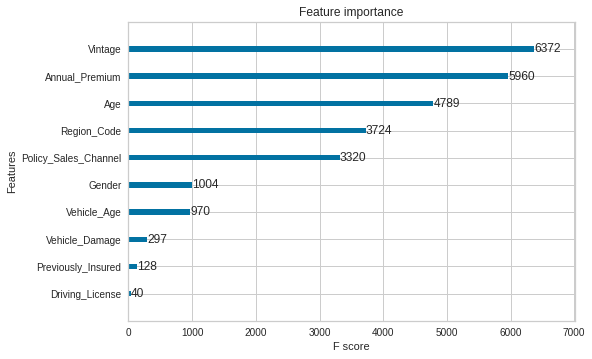

In [23]:
xgb.plot_importance(XGB_model)

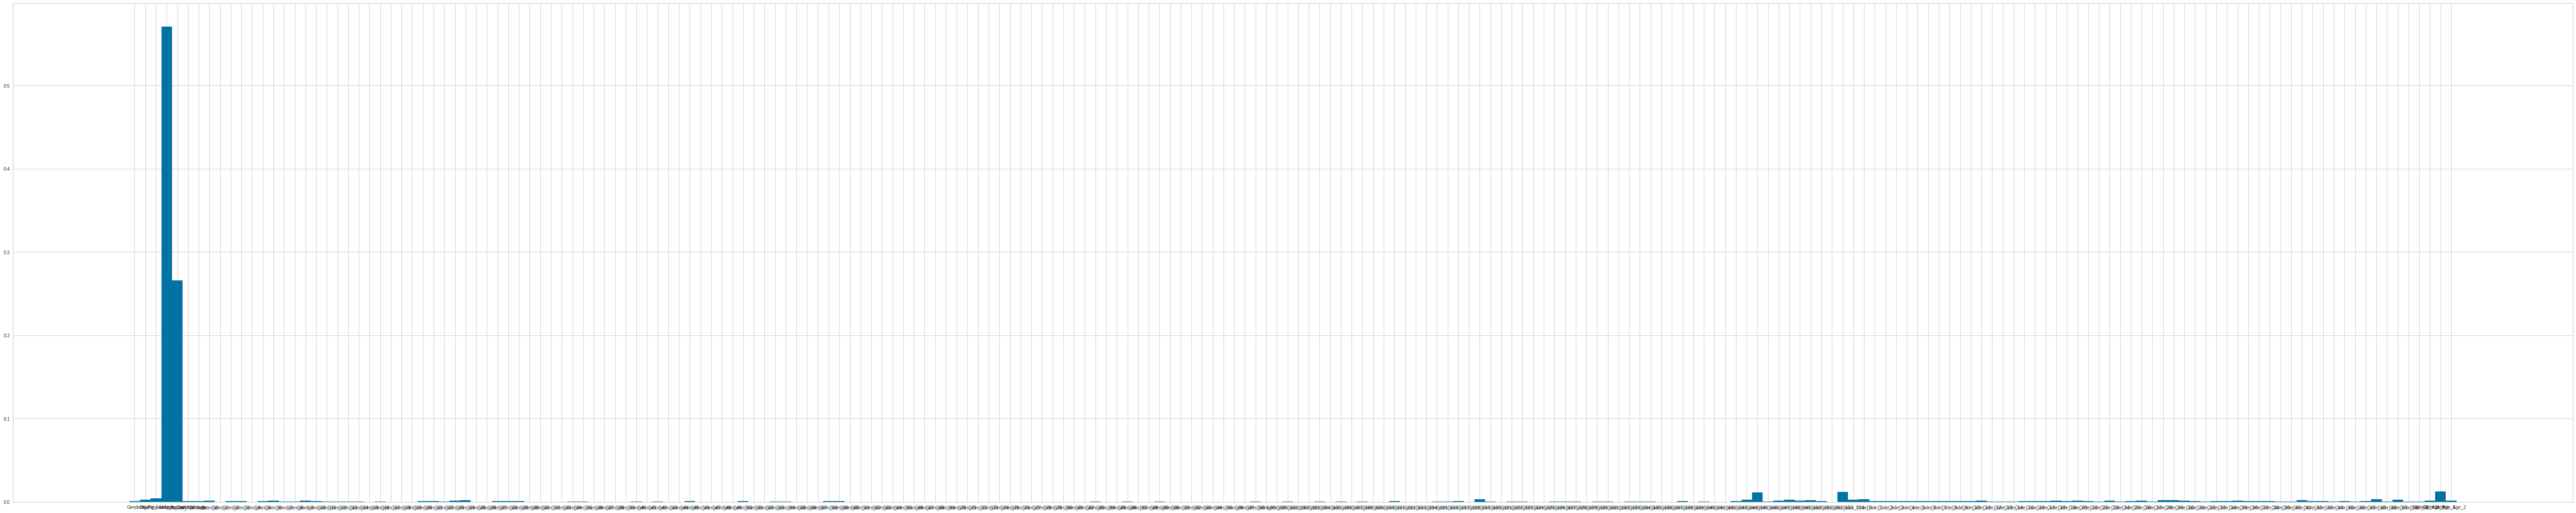

In [24]:
plt.figure(figsize=(100, 20))
plt.bar(X0_train.columns,XGB_model_01.feature_importances_, 1)
plt.show()

It's difficult to see exact feature names that influenced the model the most, but it's clearly ones from the original set of not one-hot encoded. Some of the encoded features also had some importance although few times less impactful.

Now lets try to deal with imbalance of the classes via built-in 'scale_pos_weight', although most likely it won't help much. I'll continue experimienting with XGBoost as it seems to be getting slightly better results.

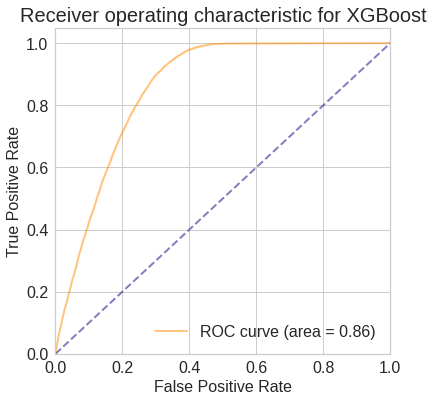

In [25]:
XGB_model_b = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          scale_pos_weight = 0.9,
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_b.fit(X_train, y_train)
XGB_preds_b = XGB_model_b.predict_proba(X_valid)
XGB_score_b = roc_auc_score(y_valid, XGB_preds_b[:,1], average = 'weighted')
XGB_class_b = XGB_model_b.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_b[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model: 0.8551
F1 score: 0.0513


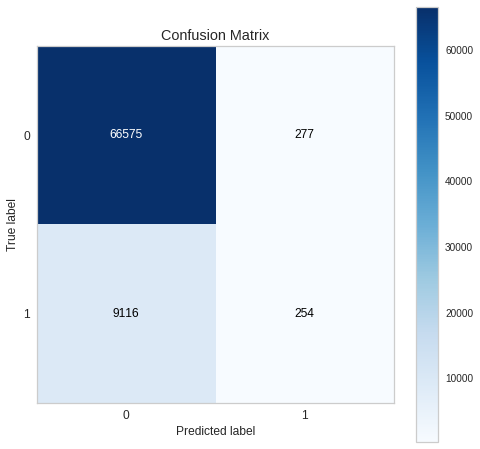

In [26]:
print('ROC AUC score for XGBoost model: %.4f'%XGB_score_b)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_b))
# print('Confusion matrix:')
# print(confusion_matrix(y_valid, XGB_class_b))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_b,
        figsize=(8,8))

As expected there is no improvement.

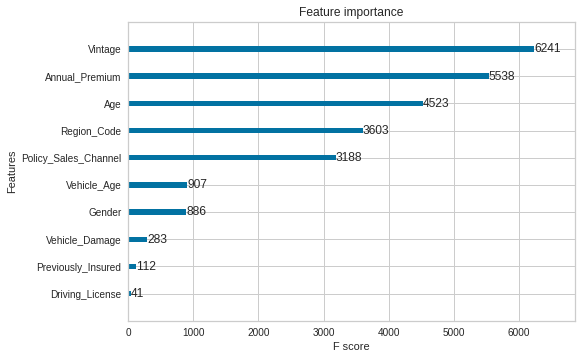

In [27]:
xgb.plot_importance(XGB_model_b)

Brute-force oversampling of Positive Response class

In [117]:
def upsample_all(df, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        df['Annual_Premium'] = ones['Annual_Premium'].apply(lambda x: x + random.randint(-1,1)* x *0.1)
        df['Age'] = ones['Age'].apply(lambda x: x + random.randint(-5,5))
        df['Vintage'] = ones['Vintage'].apply(lambda x: x + random.randint(-5,5))
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

def upsample(df, u_feature, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        if u_feature == 'Annual_Premium':
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-1,1)* x *0.05)
        else:
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-5,5))
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

try:
    df_train_corr.drop(columns = ['bin_age'], inplace = True)
except:
    print('already deleted')        

df_train_mod = df_train_corr[col_list]

# we shall preserve validation set without augmentation/over-sampling
dft, X_valid, yft, y_valid = train_test_split(df_train_mod, df_train_mod['Response'], train_size=0.8, random_state = SEED)
X_valid = X_valid.drop(columns = ['Response'])

df_train_up_a = upsample(dft.loc[dft['Response'] == 1], 'Age', 1)
df_train_up_v = upsample(dft.loc[dft['Response'] == 1], 'Vintage', 1)
df_train_up_p = upsample(dft.loc[dft['Response'] == 1], 'Annual_Premium', 1)
df_train_up3 = upsample_all(dft.loc[dft['Response'] == 1], 3)

already deleted


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [122]:
# df_ext = pd.concat([df_train_mod,df_train_up3])
# df_ext = pd.concat([df_train_mod,df_train_up_v])
df_ext = pd.concat([df_train_mod,df_train_up_a])
df_ext = pd.concat([df_ext,df_train_up_v])
# df_ext = pd.concat([df_ext,df_train_up_p])
Xe = df_ext.drop(columns = ['Response'])
# Xe = df_ext.loc[:,:'Vintage']
ye = df_ext.Response
print(ye.value_counts())
Xe.head()

0    334399
1    121390
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217
2,1,76,1,3,0,0,0,33536.0,26,183
3,1,47,1,28,0,2,1,38294.0,26,27
4,1,21,1,11,1,1,0,28619.0,152,203
5,0,29,1,41,1,1,0,27496.0,152,39


In [123]:
X_train = Xe.copy()
y_train = ye.copy()
print('Validation set target class count: ')
print(y_valid.value_counts())
print('Train set target class count with over-sampling:')
print(ye.value_counts())

Validation set target class count: 
0    66852
1     9370
Name: Response, dtype: int64
Train set target class count with over-sampling:
0    334399
1    121390
Name: Response, dtype: int64


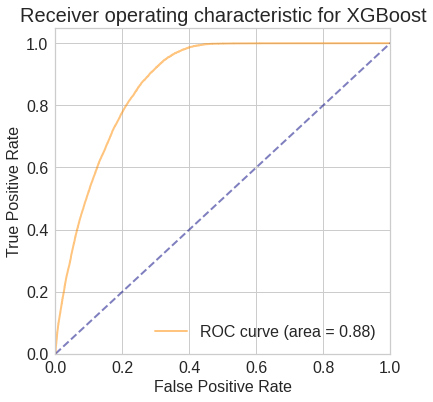

In [124]:
XGB_model_u = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_u.fit(X_train, y_train)
XGB_preds_u = XGB_model_u.predict_proba(X_valid)
XGB_score_u = roc_auc_score(y_valid, XGB_preds_u[:,1], average = 'weighted')
XGB_class_u = XGB_model_u.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_u[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model with over-sampling: 0.8786
F1 score: 0.4849


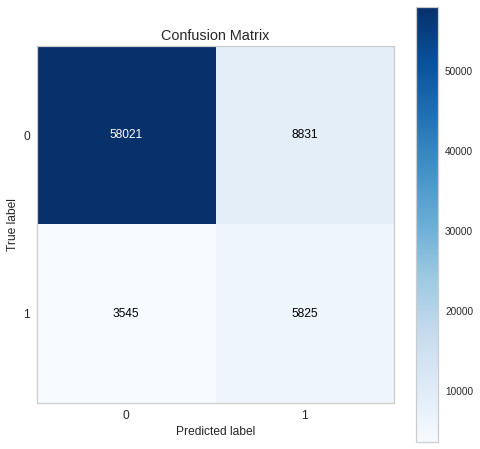

In [125]:
print('ROC AUC score for XGBoost model with over-sampling: %.4f'%XGB_score_u)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_u))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_u,
        figsize=(8,8))

Now we got much better True Positives, but False Positives are way too bad at the same time.

# Verdict
So we definitely need to find a way to balance the classes, to imporve accuarcy. And think of feature engineering...<br>
More experiments coming

**Big question** - was AUC the right metric for this problem, or would F1 be better?